In [93]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from numpy import random
import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing, pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import matplotlib
import matplotlib.pyplot as plt

In [4]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [5]:
def read_files(name):
    path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem' # use your path
    all_files = glob.glob(os.path.join(path, '*'+name+'.csv'))
    print('*'+name+'.csv')
    frame = pd.DataFrame()
    df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index(drop=True)
    return df

In [6]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['Not Mo1', 'Mo1']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, clf.predict(X_valid)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [7]:
df_train_all = read_files('train')
df_test_all = read_files('test')
df_valid_all = read_files('valid-this')

*train.csv
*test.csv
*valid-this.csv


In [8]:
# df_train_all = df_train_all.sort_values(by='IDVAR_GMT_MUTATIE')
# df_test_all = df_test_all.sort_values(by='IDVAR_GMT_MUTATIE')
# df_valid_all = df_valid_all.sort_values(by='IDVAR_GMT_MUTATIE')

In [9]:
df_train_all['fraud_label'] = np.where((df_train_all['fraud_class'] == 'Mo1'), 1, 0)
df_test_all['fraud_label'] = np.where((df_test_all['fraud_class'] == 'Mo1'), 1, 0)
df_valid_all['fraud_label'] = np.where((df_valid_all['fraud_class'] == 'Mo1'), 1, 0)

In [10]:
df_train_all.head()

,IDVAR_GMT_MUTATIE,IDVAR_META_HASH,label,fraud_class,C_000,C_001,C_002,C_003,C_004,C_005,...,V_008,V_009,V_010,V_011,V_012,V_013,V_014,V_015,V_016,fraud_label
0,2017-07-01 01:16:10,Ltp2YyhB5Oo7Ywm+L2AGaVhJxQw=,1,Mo2,0.1,0.106,0.100,0.124,0.1,0.1,...,0.100,0.102,0.105,0.102,0.136,0.105,0.111,0.05,0.100,0
1,2017-07-01 02:00:58,PeCPA86RzbqZR18/tLUvikgwUNc=,1,Mo2,0.1,0.106,0.100,0.100,0.1,0.1,...,0.100,0.102,0.105,0.102,0.142,0.105,0.111,0.05,0.100,0
2,2017-07-01 08:43:27,+WGwqT5E/+zJ6MZ9yy50pG0awb0=,1,Mo1,0.1,0.106,0.100,0.212,0.1,0.1,...,0.103,0.102,0.105,0.102,0.100,0.104,0.100,0.05,0.118,1
3,2017-07-01 08:48:11,l6glV/qzuPhE34SBB2LFE5YP1v8=,1,Mo1,0.1,0.120,0.124,0.212,0.1,0.1,...,0.103,0.102,0.105,0.102,0.176,0.118,0.108,0.05,0.100,1
4,2017-07-01 19:11:20,IR6NOzGwaD4WuJgcdphrzc+5oGA=,1,Mo1,0.1,0.116,0.100,0.102,0.1,0.1,...,0.103,0.102,0.105,0.102,0.131,0.118,0.101,0.05,0.100,1


In [11]:
df_train_all["fraud_label"].value_counts()

0    598855
1      1236
Name: fraud_label, dtype: int64

In [12]:
df_test_all["fraud_label"].value_counts()

0    597990
1       420
Name: fraud_label, dtype: int64

In [13]:
df_valid_all["fraud_label"].value_counts()

0    598069
1       409
Name: fraud_label, dtype: int64

In [14]:
X_train = df_train_all.iloc[:,4:-1]
y_train = df_train_all['fraud_label']
X_test = df_test_all.iloc[:,4:-1]
y_test = df_test_all['fraud_label']
X_valid = df_valid_all.iloc[:,4:-1]
y_valid = df_valid_all['fraud_label']

In [15]:
X_traintest = pd.concat((X_train, X_test)).reset_index(drop=True)
y_traintest = pd.concat((pd.DataFrame(y_train), pd.DataFrame(y_test))).reset_index(drop=True)

In [16]:
Counter(y_traintest.values.flatten())

Counter({0: 1196845, 1: 1656})

In [17]:
Counter(y_valid.values.flatten())

Counter({0: 598069, 1: 409})

In [18]:
def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
#    ratio={0: second_class}
    ratio={0: int(major_class/r)}
    print(C)
    with Timer('Under-sampling using '+ sampler.__class__.__name__):
        uds = sampler
        uds.set_params(ratio=ratio, random_state=0)
        X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

Counter({0: 1196845, 1: 1656})
[Under-sampling using RandomUnderSampler]
Elapsed: 131.7041780948639
X_resampled.shape: (41550, 585), y_resampled: (41550,)
y_resample:
0    39894
1     1656
dtype: int64
AUC score: 0.901
None
Counter({0: 1196845, 1: 1656})
[Under-sampling using RandomUnderSampler]
Elapsed: 102.13210391998291
X_resampled.shape: (31577, 585), y_resampled: (31577,)
y_resample:
0    29921
1     1656
dtype: int64
AUC score: 0.913
None
Counter({0: 1196845, 1: 1656})
[Under-sampling using RandomUnderSampler]
Elapsed: 95.82325291633606
X_resampled.shape: (25592, 585), y_resampled: (25592,)
y_resample:
0    23936
1     1656
dtype: int64
AUC score: 0.920
None
Counter({0: 1196845, 1: 1656})
[Under-sampling using RandomUnderSampler]
Elapsed: 124.9842619895935
X_resampled.shape: (3312, 585), y_resampled: (3312,)
y_resample:
1    1656
0    1656
dtype: int64
AUC score: 0.973
None


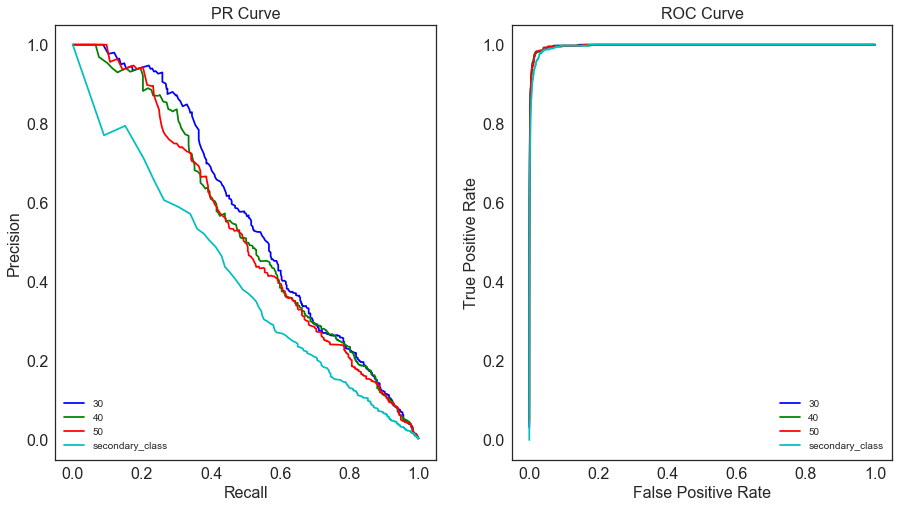

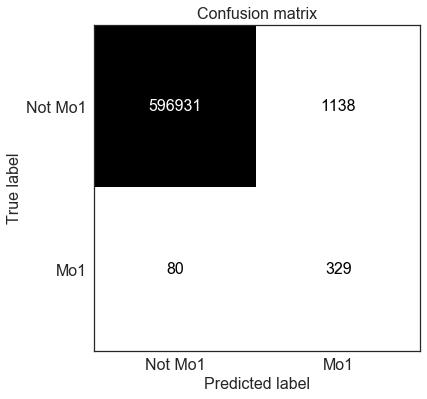

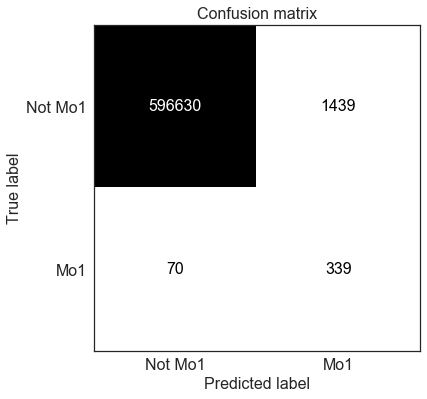

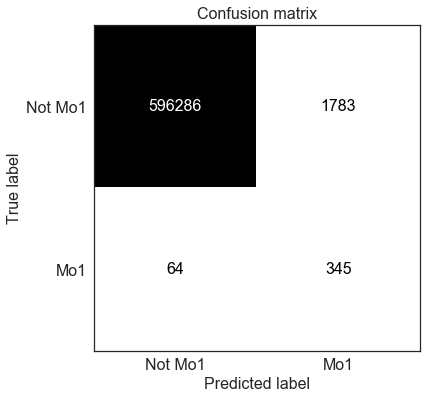

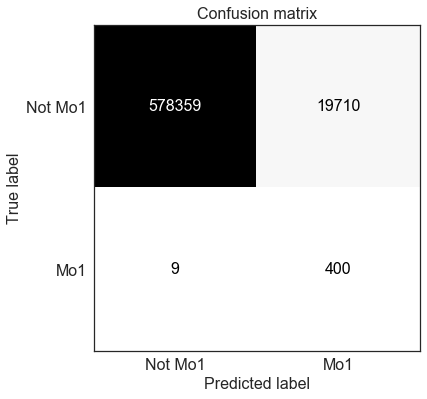

In [49]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

y = y_traintest.values.flatten()
secondary_class = (Counter(np.array(y)).most_common(1)[-1][1] / Counter(np.array(y)).most_common(2)[-1][1])

for r, k in zip([30, 40, 50, secondary_class],'bgrcmykw'):
    X_traintest_sampled, y_traintest_sampled = undersampling(X_traintest, y_traintest.values.flatten(), 
                                                             RandomUnderSampler(random_state=0), r)
    clf = RandomForestClassifier(n_estimators=500, random_state=0)#, class_weight="balanced")
    clf.fit(X_traintest_sampled, np.array(y_traintest_sampled).ravel())
#     roc_auc_score(y_valid, clf.predict(X_valid))
    print("AUC score: {:.3f}".format(roc_auc_score(y_valid, clf.predict(X_valid))))
    print(confusion_matrix_plot(X_valid, y_valid, clf))
    pred_prob = clf.predict_proba(X_valid)[:,1]
    p,r,_ = precision_recall_curve(y_valid,pred_prob)
    fpr,tpr,_ = roc_curve(y_valid,pred_prob)
    
    ax1.plot(r,p,c=k,label=r)
    ax2.plot(fpr,tpr,c=k,label=r)
ax1.legend(labels=['30', '40', '50', 'secondary_class'], loc='lower left')    
ax2.legend(labels=['30', '40', '50', 'secondary_class'], loc='lower right')

plt.show()

In [22]:
secondary_class

722.7324879227053

In [19]:
def evaluate_scores(X_valid, y_valid, clf):
    print("AUC score: {:.3f}".format(roc_auc_score(y_valid, clf.predict(X_valid))))
    print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, clf.predict(X_valid))))
    print("F1-micro score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="micro")))
#     print("F1-weighted score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="weighted")))
    print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_valid, clf.predict(X_valid))))
    print(classification_report(y_valid, clf.predict(X_valid)))

In [20]:
X_traintest_sampled, y_traintest_sampled = undersampling(X_traintest, y_traintest.values.flatten(), 
                                                             RandomUnderSampler(random_state=0), 30)

Counter({0: 1196845, 1: 1656})
[Under-sampling using RandomUnderSampler]
Elapsed: 47.11746406555176
X_resampled.shape: (41550, 585), y_resampled: (41550,)
y_resample:
0    39894
1     1656
dtype: int64


In [19]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_traintest_sampled, np.array(y_traintest_sampled).ravel())
evaluate_scores(X_valid, y_valid, clf)

AUC score: 0.901
Accuracy score: 0.998
F1-micro score: 0.998
Cohen kappa score: 0.350
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598069
          1       0.22      0.80      0.35       409

avg / total       1.00      1.00      1.00    598478



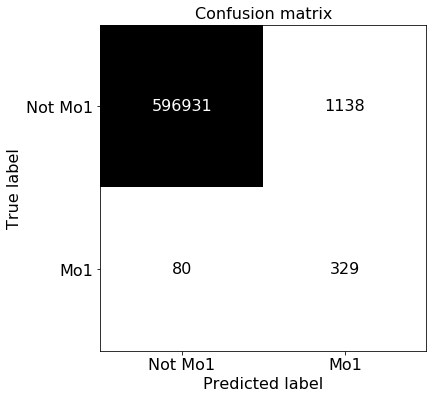

In [20]:
confusion_matrix_plot(X_valid, y_valid, clf)

In [21]:
X_traintest_sampled = pd.DataFrame(X_traintest_sampled, columns=list(X_traintest))

### Feature selection with Random Forests

In [22]:
thresholds = range(8, 13, 1)

In [23]:
n = []
cv_accuracy = []
for thresh in thresholds:
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]

    # training model
    selection_model = RandomForestClassifier(n_estimators=500, random_state=0)
    # perform cross-validation
    scores = cross_val_score(selection_model, X_traintest_selected, y_traintest_sampled, cv=5)
     # compute mean cross-validation accuracy
    accuracy = np.mean(scores)    
    cv_accuracy.append(accuracy)
    n.append(X_traintest_selected.shape[1])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_traintest_selected.shape[1], accuracy*100.0))

Thresh=8.000, n=38, Accuracy: 98.85%
Thresh=9.000, n=29, Accuracy: 98.82%
Thresh=10.000, n=26, Accuracy: 98.81%
Thresh=11.000, n=22, Accuracy: 98.79%
Thresh=12.000, n=17, Accuracy: 98.54%


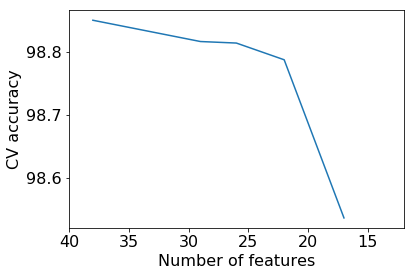

In [24]:
plt.plot(n, np.asarray(cv_accuracy)*100.0, label="cv accuracy")
plt.xlim(40, 15)
plt.xlabel("Number of features")
plt.ylabel("CV accuracy")

In [22]:
def feature_selection(thresh, X_traintest_sampled, y_traintest_sampled, X_valid):
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]
    return X_traintest_selected, X_valid_selected

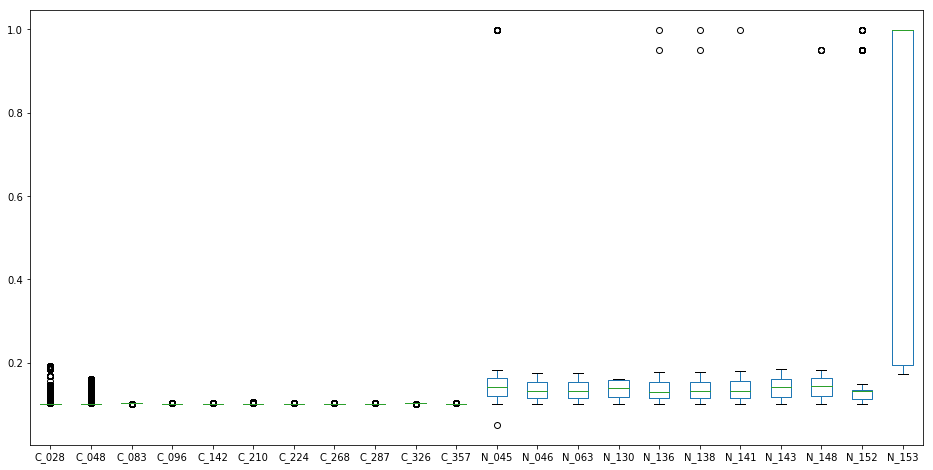

In [23]:
X_traintest_selected, X_valid_selected = feature_selection(11, X_traintest_sampled, y_traintest_sampled, X_valid)
X_traintest_selected.plot.box(figsize=(16,8))

In [24]:
X_traintest_selected.describe()

,C_028,C_048,C_083,C_096,C_142,C_210,C_224,C_268,C_287,C_326,...,N_046,N_063,N_130,N_136,N_138,N_141,N_143,N_148,N_152,N_153
count,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,...,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000,41550.000000
mean,0.100399,0.101348,0.101637,0.100050,0.100212,0.101076,0.100033,0.100050,0.100132,0.101909,...,0.134440,0.134442,0.136208,0.133345,0.134257,0.135278,0.140953,0.141303,0.127912,0.758636
std,0.004746,0.006987,0.000771,0.000312,0.000615,0.000277,0.000254,0.000312,0.000496,0.000417,...,0.021716,0.021716,0.020777,0.023557,0.023633,0.023550,0.025613,0.025646,0.052075,0.370751
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.173000
25%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.114000,0.114000,0.117000,0.114000,0.114000,0.115000,0.118000,0.120000,0.112000,0.195000
50%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.133000,0.133000,0.140000,0.130000,0.132000,0.132000,0.142000,0.143000,0.131000,0.999000
75%,0.100000,0.100000,0.102000,0.100000,0.100000,0.101000,0.100000,0.100000,0.100000,0.102000,...,0.154000,0.154000,0.158000,0.153000,0.154000,0.155000,0.160000,0.163000,0.134000,0.999000
max,0.192000,0.160000,0.102000,0.102000,0.102000,0.106000,0.102000,0.102000,0.102000,0.102000,...,0.174000,0.174000,0.160000,0.999000,0.999000,0.999000,0.184000,0.950000,0.999000,0.999000


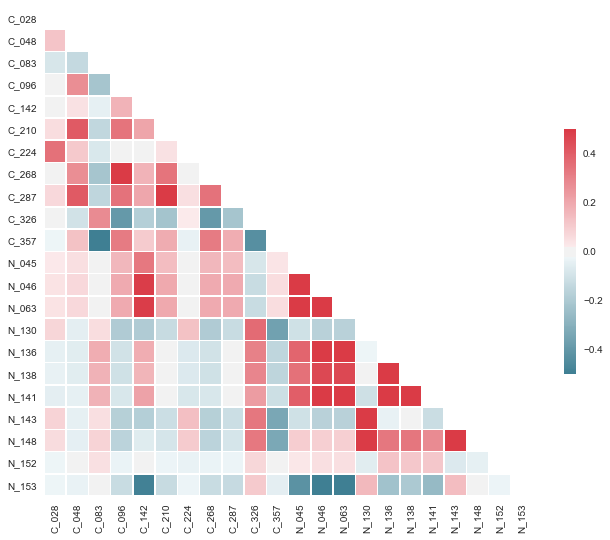

In [24]:
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=X_traintest_selected,
                 columns=list(X_traintest_selected))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
corr.abs().sum().mean()

4.971572687931708

In [39]:
def classification(classifier):
    model = classifier
    model.fit(X_traintest_selected, y_traintest_sampled)
#     cv_score = np.mean(cross_val_score(model, X_traintest_selected, y_traintest_sampled, cv=5))
#     test_score = model.score(X_valid_selected, y_valid)
    print('Classifier parameters:', model.get_params)
#     print("Cross-validation accuracy: {:.3f}".format(cv_score))    
#     print('Test score: {:.3f}'.format(test_score))
    return model#, cv_score, test_score

In [60]:
def plot_pr_roc_curve_scikit(clf, label, color, marker):
    pred = clf.predict(X_valid_selected)
    pred_prob = clf.predict_proba(X_valid_selected)[:,1]

#     print("AUC score: {:.3f}".format(roc_auc_score(label, pred)))
#     print(classification_report(label, pred))
#     print(confusion_matrix_plot(X_valid_selected, label, clf))
    
    precision, recall, thresholds_pr = precision_recall_curve(label, pred_prob)
    fpr, tpr, thresholds_roc = roc_curve(label, pred_prob)

    ax1.plot(recall, precision, c=color, label=par)
    ax2.plot(fpr, tpr, c=color, label=par)
    
    close_default_pr = np.argmin(np.abs(thresholds_pr - 0.5))
    close_default_roc = np.argmin(np.abs(thresholds_roc - 0.5))

    ax1.plot(recall[close_default_pr], precision[close_default_pr], marker=marker, markersize=12,
             fillstyle="none", c=color, mew=2)#, label=par)
    ax2.plot(fpr[close_default_roc], tpr[close_default_roc], marker=marker, markersize=12,
             fillstyle="none", c=color, mew=2, label=par)
    return ax1, ax2
#     print(fpr, tpr, precision, recall, thresholds_pr)

In [58]:
clf = XGBClassifier(objective='multi:softmax', num_class= 2, max_depth=9, min_child_weight=7, n_estimators=100, 
                   subsample=1.0, colsample_bytree=0.7)
clf.fit(X_traintest_selected, y_traintest_sampled)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=2, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
       

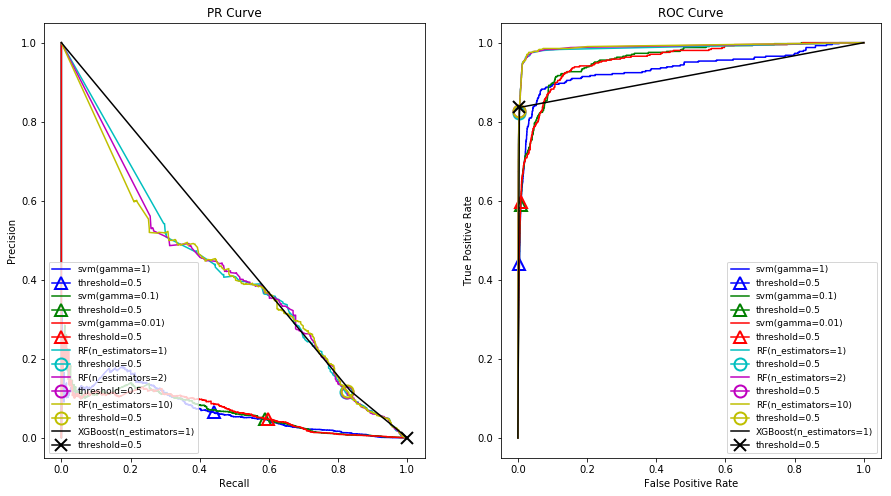

In [66]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


label = y_valid
for par, color in zip([10, 0.1, 0.01], 'bgr'):
    clf =  classification(SVC(gamma=par, probability=True, random_state=0))
    plot_pr_roc_curve_scikit(clf, label, color, '^')

for par, color in zip([100, 200, 500], 'cmy'):
    clf =  classification(RandomForestClassifier(n_estimators=par, random_state=0))
    plot_pr_roc_curve_scikit(clf, label, color, 'o')

clf = classification(XGBClassifier(objective='multi:softmax', num_class= 2, max_depth=9, min_child_weight=7, 
                                   n_estimators=100, subsample=1.0, colsample_bytree=0.7, random_state=0))
plot_pr_roc_curve_scikit(clf, label, 'k', 'x')

ax1.legend(labels=['svm(gamma=1)', 'threshold=0.5', 'svm(gamma=0.1)', 
                   'threshold=0.5', 'svm(gamma=0.01)', 'threshold=0.5',
                  'RF(n_estimators=1)', 'threshold=0.5', 'RF(n_estimators=2)', 
                   'threshold=0.5', 'RF(n_estimators=10)', 'threshold=0.5',
                  'XGBoost(n_estimators=1)', 'threshold=0.5'], loc='lower left', prop={'size': 9})    
ax2.legend(labels=['svm(gamma=1)', 'threshold=0.5', 'svm(gamma=0.1)', 
                   'threshold=0.5', 'svm(gamma=0.01)', 'threshold=0.5',
                  'RF(n_estimators=1)', 'threshold=0.5', 'RF(n_estimators=2)', 
                   'threshold=0.5', 'RF(n_estimators=10)', 'threshold=0.5',
                  'XGBoost(n_estimators=1)', 'threshold=0.5'], loc='lower right', prop={'size': 9}) 

plt.show()

In [81]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()],
     'classifier__kernel': ['rbf'],
     'classifier__gamma': [0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.01, 0.1, 1, 10, 100]}
#     {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
#      'classifier__n_estimators': [100, 500, 1000],
#      'classifier__bootstrap': [True, False],
#      'classifier__criterion': ['gini', 'entropy']},
]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_traintest_selected, y_traintest_sampled)
print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_valid_selected, y_valid)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.986
Test set score: 0.995
Best parameters: {'classifier__C': 100, 'classifier__gamma': 100, 'classifier__kernel': 'rbf', 'classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}


In [82]:
svm_1 = classification(SVC(C=100, gamma=100, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>


In [78]:
rf_1 = classification(RandomForestClassifier(n_estimators=100, random_state=0))
rf_2 = classification(RandomForestClassifier(n_estimators=200, random_state=0))
rf_3 = classification(RandomForestClassifier(n_estimators=500, random_state=0))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Classifier parameters: <bound method BaseEstimator.get

In [94]:
def categorize_samples(clf):
    Mo1_tp = y_valid.index[(y_valid==1) & (clf.predict(X_valid_selected)==1)].tolist()
#     Mo1_fp = y_valid.index[(y_valid==0) & (clf.predict(X_valid_selected)==1)].tolist()
#     Mo1_tn = y_valid.index[(y_valid==0) & (clf.predict(X_valid_selected)==0)].tolist()
#     Mo1_fn = y_valid.index[(y_valid==1) & (clf.predict(X_valid_selected)==0)].tolist()

    Mo1_tp_samples = random.choice(Mo1_tp, 100)   
#     Mo1_fp_samples = random.choice(Mo1_fp, len(Mo1_tp))
#     Mo1_tn_samples = random.choice(Mo1_tn, len(Mo1_fn))
    return Mo1_tp_samples#, Mo1_fp_samples, Mo1_tn_samples, Mo1_fn

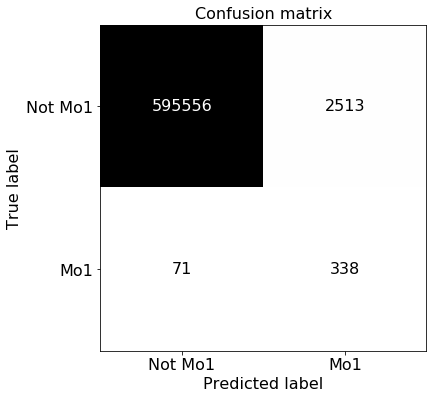

In [79]:
confusion_matrix_plot(X_valid_selected, y_valid, rf_3)

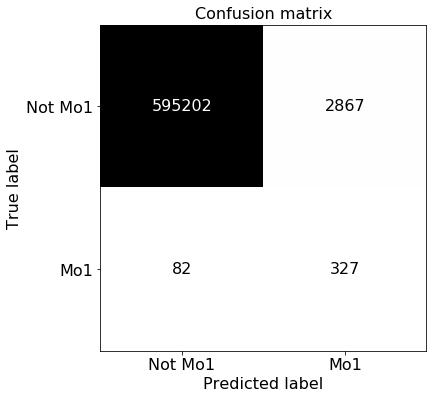

In [83]:
confusion_matrix_plot(X_valid_selected, y_valid, svm_1)

In [28]:
def shap_explain(X_traintest_selected, X_valid_selected, clf, samples):
    explainer = shap.KernelExplainer(clf.predict_proba, X_traintest_selected)
    shap_values = explainer.shap_values(X_valid_selected.loc[samples])
    return shap_values

In [95]:
Mo1_tp_samples_svm_1 = categorize_samples(svm_1)

In [ ]:
shap_values_tp_svm_1 = shap_explain(X_traintest_selected, X_valid_selected, svm_1, Mo1_tp_samples_svm_1)

  2%|▏         | 2/100 [2:02:36<100:08:00, 3678.38s/it]

In [ ]:
Mo1_tp_svm_2, Mo1_fp_samples_svm_2, Mo1_tn_samples_svm_2, Mo1_fn_svm_2 = categorize_samples(svm_2)
Mo1_tp_svm_3, Mo1_fp_samples_svm_3, Mo1_tn_samples_svm_3, Mo1_fn_svm_3 = categorize_samples(svm_3)
Mo1_tp_svm_4, Mo1_fp_samples_svm_4, Mo1_tn_samples_svm_4, Mo1_fn_svm_4 = categorize_samples(svm_4)
shap_values_tp_svm_2 = shap_explain(X_traintest_selected, X_valid_selected, svm_2, Mo1_tp_svm_2)
shap_values_tp_svm_3 = shap_explain(X_traintest_selected, X_valid_selected, svm_3, Mo1_tp_svm_3)
shap_values_tp_svm_4 = shap_explain(X_traintest_selected, X_valid_selected, svm_4, Mo1_tp_svm_4)

### XGBoost

In [62]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)

In [26]:
gridsearch_params = [
    (max_depth, min_child_weight, n_estimators, subsample, colsample)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
    for n_estimators in [100, 200, 500, 1000]
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [50]:
params = {'max_depth':20, 'n_estimators':500,
         'objective': 'multi:softmax', 'num_class': 5
}

In [51]:
# Define initial best params and MAE
num_boost_round = 999
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight, n_estimators, subsample, colsample in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, n_estimators={}, subsample={}, colsample={}".format(
                             max_depth,
                             min_child_weight,
                             n_estimators,
                             subsample,
                             colsample))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['n_estimators'] = n_estimators
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

# for subsample, colsample in reversed(gridsearch_params):
#     print("CV with subsample={}, colsample={}".format(
#                              subsample,
#                              colsample))

#     # Update the parameters
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample
    
#     params['objective'] = 'multi:softmax'
#     params['num_class'] = 5
    
    # Run CV
    cv_results = xgboost.cv(
        params,
        xgb_traintest,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10
    )

    # Update best Merror
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\tMerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth, min_child_weight, n_estimators, subsample, colsample)
print("Best params: {}, {}, {}, {}, {}, Merror: {}".format(best_params[0], best_params[1], best_params[2], 
        best_params[3], best_params[4], min_merror))

#         best_params = (subsample, colsample)
# print("Best params: {}, {}, Merror: {}".format(best_params[0], best_params[1], min_merror))

CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.7
	Merror 0.011432000000000001 for 26 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.8
	Merror 0.0112394 for 15 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.9
	Merror 0.0113838 for 15 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=1.0
	Merror 0.0114802 for 12 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.7
	Merror 0.010974800000000002 for 41 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.8
	Merror 0.0112154 for 23 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.9
	Merror 0.0116484 for 19 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.0113116 for 27 rounds
CV with max_depth=

	Merror 0.0116244 for 25 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.7, colsample=1.0
	Merror 0.0112152 for 54 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.7
	Merror 0.0115042 for 23 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.8
	Merror 0.011023000000000002 for 56 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.9
	Merror 0.011287599999999998 for 26 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.011215600000000001 for 26 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.7
	Merror 0.011504200000000001 for 22 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0115522 for 28 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=

	Merror 0.011576199999999998 for 14 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.8, colsample=0.9
	Merror 0.011432000000000001 for 21 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.0112634 for 14 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.7
	Merror 0.011191 for 29 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0113838 for 20 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.011456200000000001 for 26 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.011071 for 26 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.0109024 for 40 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0

	Merror 0.0112876 for 36 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0112154 for 36 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.011335799999999998 for 17 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.0113118 for 34 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.011215600000000001 for 21 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.011070799999999999 for 25 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.0112396 for 26 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.0113598 for 40 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.7

	Merror 0.011071000000000001 for 61 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.011335800000000002 for 42 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.0111192 for 33 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.0111432 for 31 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.0112876 for 42 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.0112394 for 35 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.7
	Merror 0.011504200000000001 for 26 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.011624599999999999 for 22 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7, co

	Merror 0.0115766 for 11 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.011167199999999999 for 14 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.011384 for 31 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.011432000000000001 for 15 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.7
	Merror 0.0111912 for 22 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.0112636 for 16 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.0115764 for 23 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.011167 for 26 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.01

	Merror 0.0114078 for 35 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.7
	Merror 0.0111432 for 25 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.0112634 for 15 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.01148 for 29 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.011600599999999999 for 10 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.0114802 for 23 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.0114322 for 25 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=0.9
	Merror 0.011047199999999998 for 38 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=1.0
	Merror 0.01

	Merror 0.011432000000000001 for 15 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.0116004 for 20 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.0116486 for 25 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.011432 for 25 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.011504200000000001 for 19 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.9
	Merror 0.011407800000000001 for 32 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=1.0
	Merror 0.011359600000000001 for 22 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.9, colsample=0.7
	Merror 0.011552399999999999 for 19 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsamp

	Merror 0.011480200000000001 for 13 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.011456000000000001 for 28 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.011456 for 27 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.9
	Merror 0.011432 for 15 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=1.0
	Merror 0.0114078 for 35 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.7
	Merror 0.011191399999999999 for 33 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.8
	Merror 0.0113118 for 24 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.9
	Merror 0.0113838 for 17 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=1.0
	

In [52]:
best_params

(9, 7, 100, 1.0, 0.7)

In [63]:
# use validation set to choose # of trees
params = {'max_depth':10, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2,
          'early_stopping_rounds':10
#           'objective': 'binary:logistic'
}

params['max_depth'] = 9
params['min_child_weight'] = 7
params['n_estimators'] = 100
params['subsample'] = 1.0
params['colsample_bytree'] = .7

In [64]:
params

{'colsample_bytree': 0.7,
 'early_stopping_rounds': 10,
 'max_depth': 9,
 'min_child_weight': 7,
 'n_estimators': 100,
 'num_class': 2,
 'objective': 'multi:softmax',
 'subsample': 1.0}

In [65]:
xgb = xgboost.train(params, xgb_traintest, 100)

In [65]:
# ypred_bst = np.array(xgb.predict(xgb_valid))
# ypred_bst = ypred_bst > 0.5  
# ypred_bst = ypred_bst.astype(int)

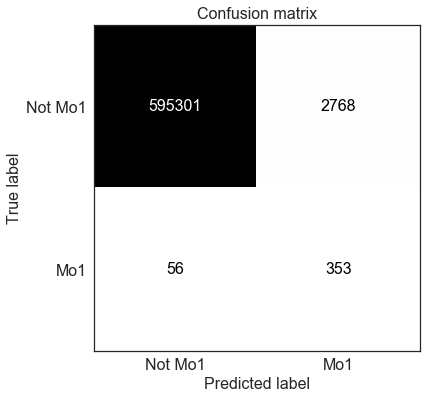

In [30]:
confusion_matrix_plot(xgb_valid, y_valid, xgb)

In [26]:
def evaluate_scores(X_valid, y_valid, clf):
    print("AUC score: {:.3f}".format(roc_auc_score(y_valid, clf.predict(X_valid))))
    print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, clf.predict(X_valid))))
    print("F1-micro score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="micro")))
#     print("F1-weighted score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="weighted")))
    print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_valid, clf.predict(X_valid))))
    print(classification_report(y_valid, clf.predict(X_valid)))

In [32]:
evaluate_scores(xgb_valid, y_valid, xgb)

AUC score: 0.929
Accuracy score: 0.995
F1-micro score: 0.995
Cohen kappa score: 0.199
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598069
          1       0.11      0.86      0.20       409

avg / total       1.00      1.00      1.00    598478



In [72]:
print("AUC score: {:.3f}".format(roc_auc_score(y_traintest_sampled, xgb.predict(xgb_traintest))))

AUC score: 0.978


In [27]:
Mo1 = y_valid.index[(y_valid==1) & (xgb.predict(xgb_valid)==1)].tolist()

In [98]:
Mo1_tp = y_valid.index[(y_valid==1) & (xgb.predict(xgb_valid)==1)].tolist()
Mo1_fp = y_valid.index[(y_valid==0) & (xgb.predict(xgb_valid)==1)].tolist()
Mo1_tn = y_valid.index[(y_valid==0) & (xgb.predict(xgb_valid)==0)].tolist()
Mo1_fn = y_valid.index[(y_valid==1) & (xgb.predict(xgb_valid)==0)].tolist()

Mo1_fp_samples = random.choice(Mo1_fp, len(Mo1_tp))
Mo1_tn_samples = random.choice(Mo1_tn, len(Mo1_fn))

In [29]:
pd.DataFrame(y_valid).to_csv("y_valid_Mo1.csv", sep='\t')
pd.DataFrame(X_valid_selected).to_csv("X_valid_selected_Mo1.csv", sep='\t')
pd.DataFrame(X_traintest_selected).to_csv("X_traintest_selected_Mo1.csv", sep='\t')
pd.DataFrame(y_traintest_sampled).to_csv("y_traintest_sampled_Mo1.csv", sep='\t')

In [68]:
xgb_valid_Mo1_tp = xgboost.DMatrix(X_valid_selected.iloc[Mo1_tp,:], label=y_valid.loc[Mo1_tp])
xgb_valid_Mo1_fp = xgboost.DMatrix(X_valid_selected.iloc[Mo1_fp_samples,:], label=y_valid.loc[Mo1_fp_samples])
xgb_valid_Mo1_tn = xgboost.DMatrix(X_valid_selected.iloc[Mo1_tn_samples,:], label=y_valid.loc[Mo1_tn_samples])
xgb_valid_Mo1_fn = xgboost.DMatrix(X_valid_selected.iloc[Mo1_fn,:], label=y_valid.loc[Mo1_fn])

In [69]:
shap_values_xgb_Mo1_tp = xgb.predict(xgb_valid_Mo1_tp, pred_contribs=True)
shap_values_xgb_Mo1_fp = xgb.predict(xgb_valid_Mo1_fp, pred_contribs=True)
shap_values_xgb_Mo1_tn = xgb.predict(xgb_valid_Mo1_tn, pred_contribs=True)
shap_values_xgb_Mo1_fn = xgb.predict(xgb_valid_Mo1_fn, pred_contribs=True)

In [56]:
shap.force_plot(shap_values_xgb_Mo1_tp[:, 1, :], X_valid_selected.iloc[Mo1_tp,:])

In [57]:
shap.force_plot(shap_values_xgb_Mo1_fp[:, 1, :], X_valid_selected.iloc[Mo1_fp,:])

In [95]:
np.var(shap_values_xgb_Mo1_tp[:, 1, :], axis=1).mean()

0.33811539

In [98]:
np.var(shap_values_xgb_Mo1_fp[:, 1, :], axis=1).mean()

0.25214946

In [97]:
shap.force_plot(shap_values_xgb_Mo1_fn[:, 1, :], X_valid_selected.iloc[Mo1_fn,:])

NameError: name 'shap_values_xgb_Mo1_fn' is not defined

In [70]:
shap.force_plot(shap_values_xgb_Mo1_tn[:, 1, :], X_valid_selected.iloc[Mo1_tn,:])

In [39]:
shap_interaction_values_Mo1 = xgb.predict(xgb_valid_Mo1, pred_interactions=True)

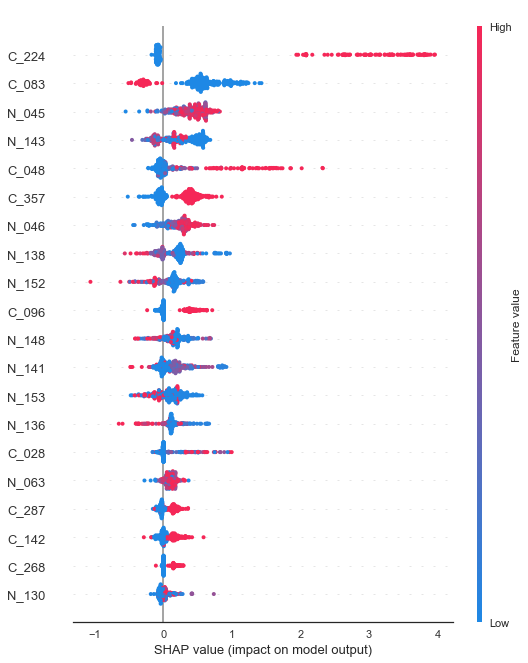

In [40]:
shap.summary_plot(shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:])

In [41]:
shap.force_plot(shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:])
# i = 12
# shap.force_plot(shap_values_xgb_Mo1[:, 1, :][i], X_valid_selected.iloc[Mo1,:].iloc[i, :])
# shap_values_xgb_Mo1[:, 1, :][i]

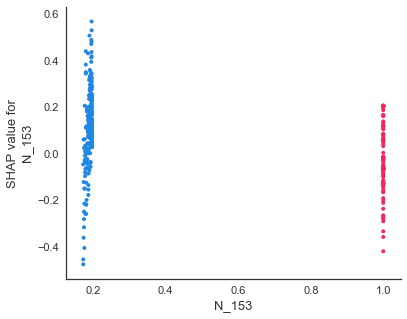

In [58]:
shap.dependence_plot("N_153", shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:],
                     interaction_index="N_153")